In [1]:
from hydra.experimental import compose
from hydra import initialize_config_dir
import hydra
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import cdvae
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import seaborn as sns

### Get CDVAE models

In [2]:
import os

os.environ["PROJECT_ROOT"] = "/mnt/c/Users/Lenovo/Downloads/cdvae2"
os.environ["HYDRA_JOBS"] = "/mnt/c/Users/Lenovo/Downloads/cdvae2"
os.environ["WABDB_DIR"] = "/mnt/c/Users/Lenovo/Downloads/cdvae2"

Models trained on other computers have the path to encoder written in the checkpoint file.
We need to load the checkpoint file, point it to the correct path on this computer and then resave it to a different file.

In [3]:
model_path = Path("/mnt/c/Users/Lenovo/Downloads/cdvae2/singlerun/2023-05-18/mp_20")

with initialize_config_dir(str(model_path)):
    ckpts = list(model_path.glob('epoch*.ckpt'))
    if len(ckpts) > 0:
        ckpt_epochs = np.array(
            [int(ckpt.parts[-1].split('-')[0].split('=')[1]) for ckpt in ckpts])
        ckpt = str(ckpts[ckpt_epochs.argsort()[-1]])
        
checkpoint = torch.load(ckpt, map_location=torch.device('cpu'))

gemnet_path = Path(cdvae.__file__).parent / "pl_modules/gemnet/gemnet-dT.json"
checkpoint["hyper_parameters"]["decoder"]["scale_file"] = str(gemnet_path)
ckpt = model_path / "checkpoint_edit.ckpt"
torch.save(checkpoint, model_path / "checkpoint_edit.ckpt")

In [4]:
with initialize_config_dir(str(model_path)):
    # load config
    cfg = compose(config_name='hparams')
    
    # load model
    model = hydra.utils.instantiate(
        cfg.model,
        optim=cfg.optim,
        data=cfg.data,
        logging=cfg.logging,
        _recursive_=False,
    )
    
    model = model.load_from_checkpoint(ckpt)
    model.lattice_scaler = torch.load(model_path / 'lattice_scaler.pt')
    model.scaler = torch.load(model_path / 'prop_scaler.pt')

/home/fhj/anaconda3/envs/cdvae/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


### Load data

In [5]:
# override batch size
#cfg.data.datamodule.batch_size = {"train": 128, "test": 128, "val": 128}

datamodule = hydra.utils.instantiate(
    cfg.data.datamodule, _recursive_=False, scaler_path=model_path
)
datamodule.setup('test')
test_loader = datamodule.test_dataloader()[0]    
batches = list(test_loader)

  0%|          | 0/9046 [00:00<?, ?it/s]

/home/fhj/anaconda3/envs/cdvae/lib/python3.8/site-packages/pymatgen/io/cif.py:1193: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn(
/home/fhj/anaconda3/envs/cdvae/lib/python3.8/site-packages/pymatgen/io/cif.py:1193: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn(
/home/fhj/anaconda3/envs/cdvae/lib/python3.8/site-packages/pymatgen/io/cif.py:1193: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn(
/home/fhj/anaconda3/envs/cdvae/lib/python3.8/site-packages/pymatgen/io/cif.py:1193: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn(
/home/fhj/anaconda3/envs

In [ ]:
# For loading small dataset in cpu, test dataset for example. Large dataset is generated by GPUs. 
mu, log_var, z = model.encode(batches[0])
for i in range(1, len(batches)):
    mu_i, log_var_i, z_i = model.encode(batches[i])
    mu = torch.cat((mu, mu_i), 0)
    log_var = torch.cat((log_var, log_var_i), 0)
    z = torch.cat((z, z_i), 0)

- frac_coords is fractional coordinates (num_structures * num_atoms, 3)
- y is target property
- edge_index defines the graph ([from_index, to_index], total_num_bonds)
- to_jimages is whether a bond crosses a periodic boundary (total_num_bonds, 3)
- angles is cell angles (num_structures, 3)
- lengths is cell lengths (num_structures, 3)
- num_atoms is number of atoms per structure (num_structures, )
- num_bonds is number of bonds per structure (num_structures, )
- atom_types is atomic number (num_structures * num_atoms, )
- batch is which atom belongs to which structure (num_structures * num_atoms, )

### Use features for t-sne

In [5]:
# Test dataset and latent vectors mu, log_var, and z

mu = pd.read_csv(model_path/"mu") 
log_var = pd.read_csv(model_path/"log_var") 
z = pd.read_csv(model_path/"z") 
test = pd.read_csv("data/mp_20/test.csv")

In [6]:
# Latent vectors mu, log_var, and z for all mp_20 dataset

mu = pd.read_csv(model_path/"mu.csv") 
log_var = pd.read_csv(model_path/"log_var.csv") 
z = pd.read_csv(model_path/"z.csv")
test = pd.read_csv("data/mp_20/test.csv")
train = pd.read_csv("data/mp_20/train.csv")
val = pd.read_csv("data/mp_20/val.csv")

In [11]:
mp = pd.concat([test,train,val])
mp.shape

(45229, 9)

In [12]:
band_gap = mp["band_gap"]
band_gap.max()

17.9023

In [7]:
m_l = pd.concat([mu,log_var], axis=1)

### Use plt.scatter

In [13]:
# Classify the value of band gap, discrete
'''def plt_tsne(data,perp):
    tsne = TSNE(n_components=2, perplexity=perp, init="random").fit_transform(data)
    df_tsne = pd.DataFrame(tsne)
    
    cmap = (colors.ListedColormap(['grey', 'red', 'pink'])
        .with_extremes(over='0.25', under='0.75'))
    bounds = [0, 1, 2.5, 18]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    plt.scatter(df_tsne[0], df_tsne[1], c=band_gap, alpha=0.5,cmap=cmap,s=1,norm=norm)
    plt.xlabel('Training set size', fontsize = 14)
    plt.ylabel('RMSE', fontsize = 14) 
    plt.colorbar()
    return plt.show()'''

In [17]:
# Continuous plot of band gap
def plt_tsne(data,perp):
    tsne = TSNE(n_components=2, perplexity=perp, init="random").fit_transform(data)
    df_tsne = pd.DataFrame(tsne)
    
    plt.scatter(df_tsne[0], df_tsne[1], c=band_gap, alpha=0.5,cmap="plasma",s=1)
    plt.xlabel('tsne_1', fontsize = 14)
    plt.ylabel('tsne_2', fontsize = 14) 
    plt.colorbar()
    return plt.show()

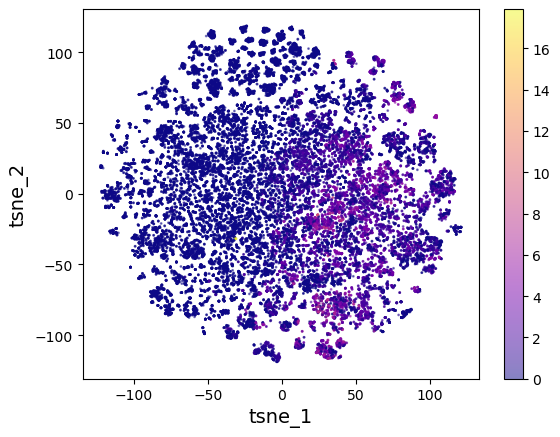

In [16]:
plt_tsne(m_l, 30)

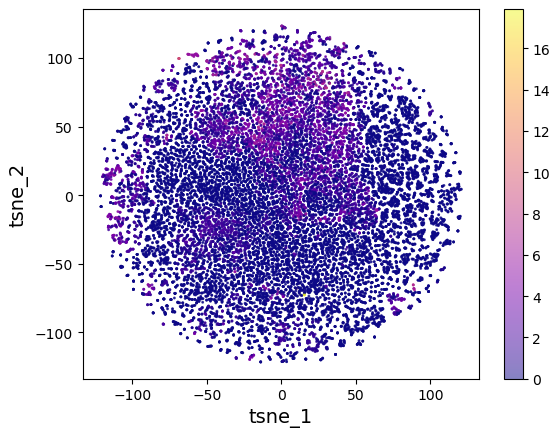

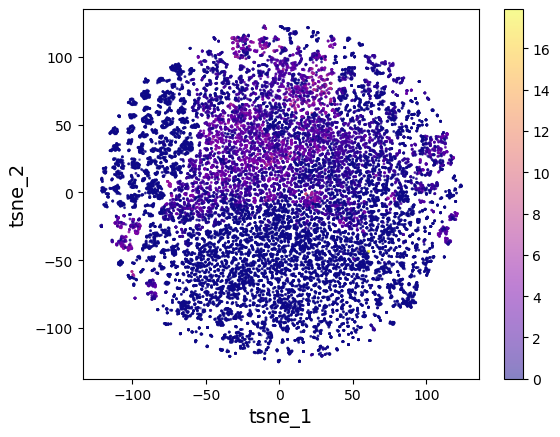

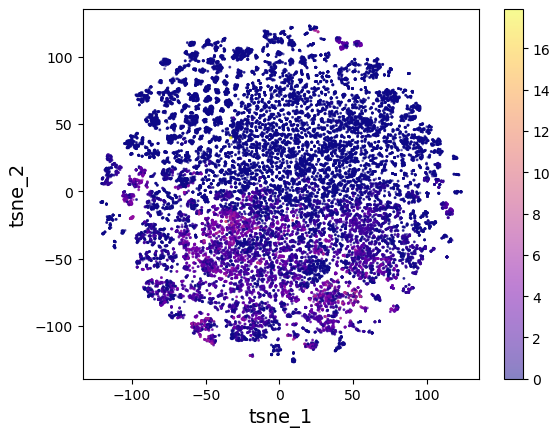

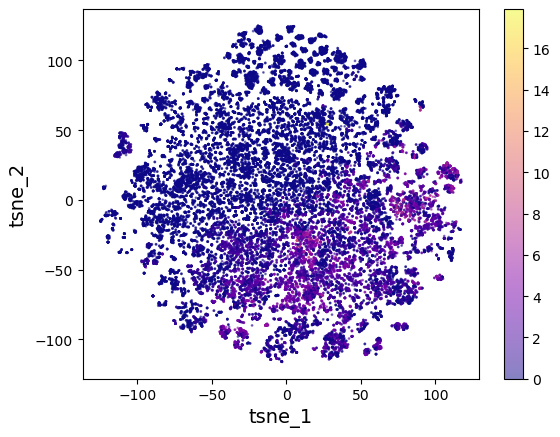

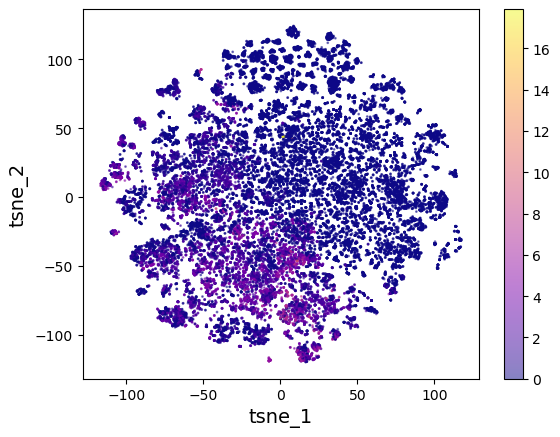

In [13]:
perp=[5,10,20,30,40]
for i in perp:
    plt_tsne(m_l, i)

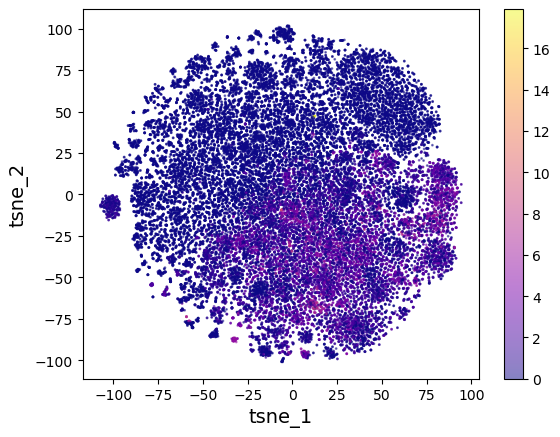

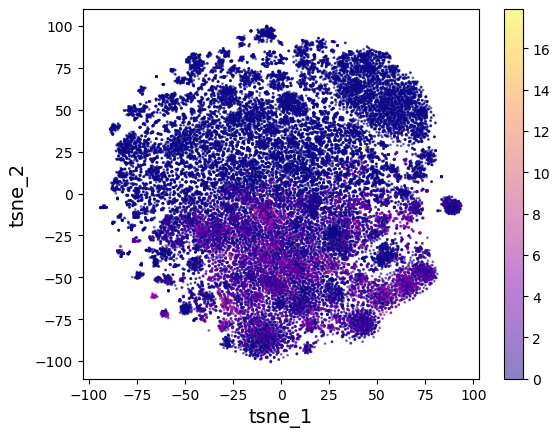

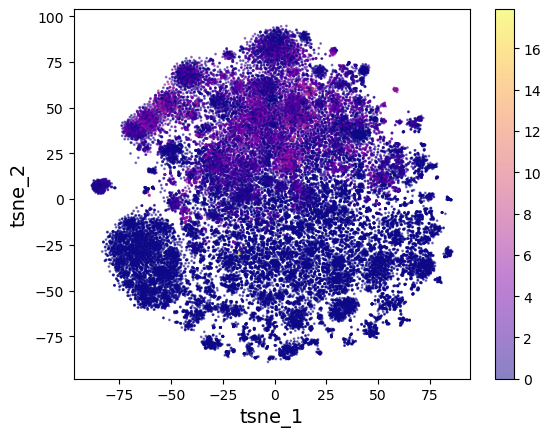

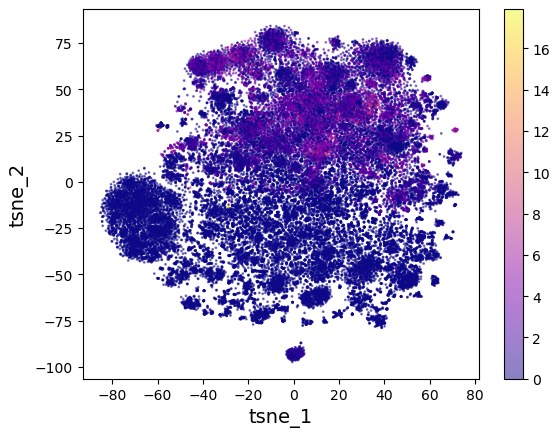

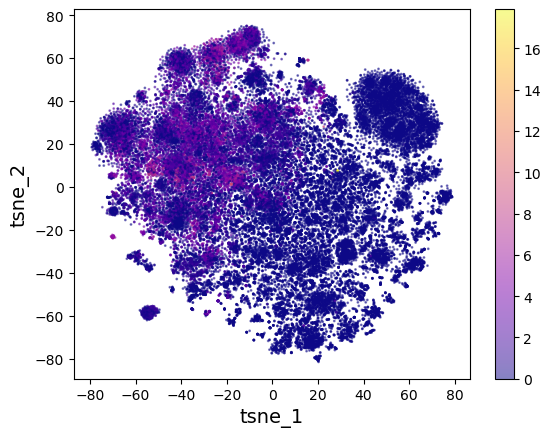

In [11]:
perp=[5,10,20,30,40]
for i in perp:
    plt_tsne(z,i)

### Use sns.scatterplot

- Used for testing, not for report

In [16]:
def plot_tsne(data,perp):
    tsne = TSNE(n_components=2, perplexity=perp, init="random").fit_transform(data)
    df_tsne = pd.DataFrame(tsne)
    df_tsne["band_gap"] = new_band_gap
    plt.figure(figsize=(16,10))
    plot = sns.scatterplot(
            x=df_tsne[0], y=df_tsne[1],
            palette=sns.color_palette("hls", 3),
            hue=df_tsne["band_gap"],
            data=df_tsne,
            alpha=0.5
        )
    return plot

<Axes: xlabel='0', ylabel='1'>

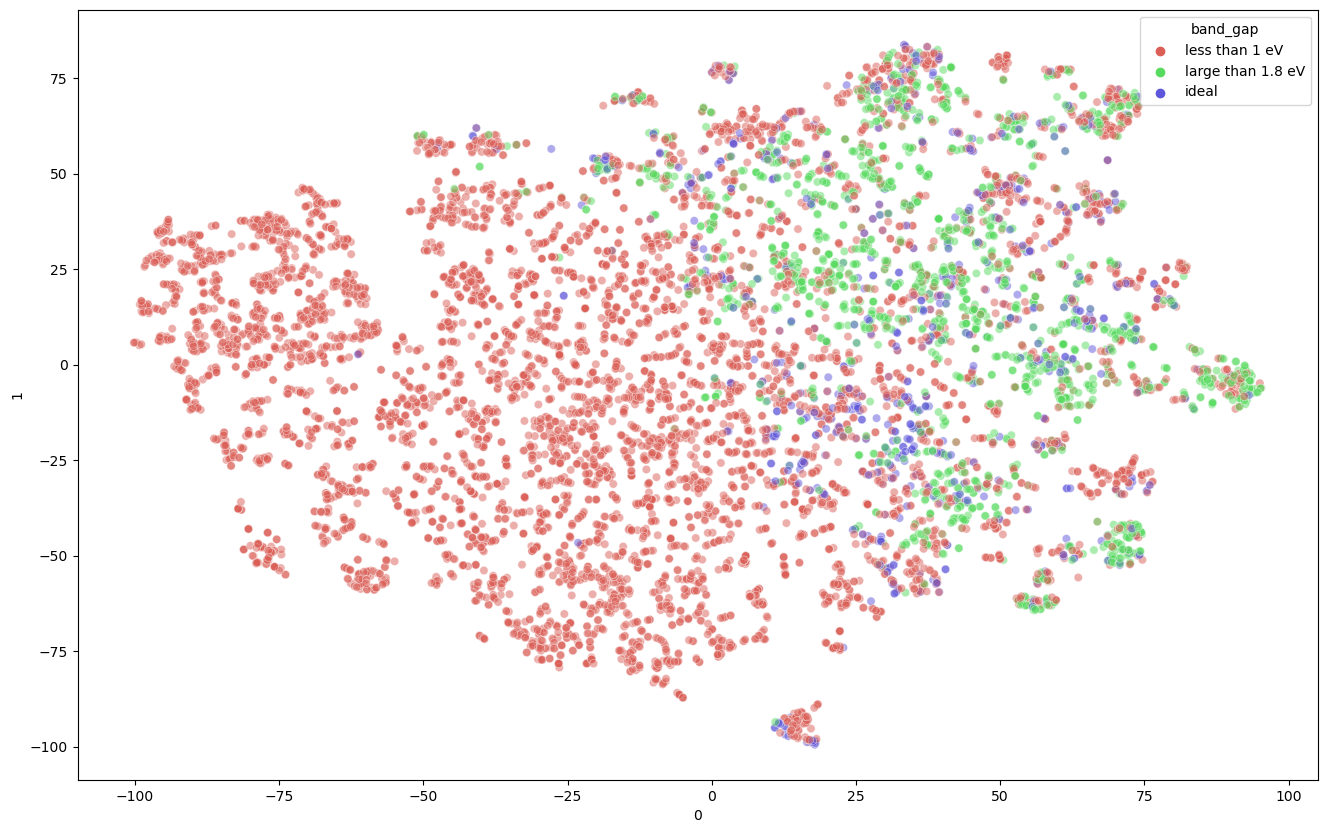

In [23]:
plot_tsne(m_l,25)

<Axes: xlabel='0', ylabel='1'>

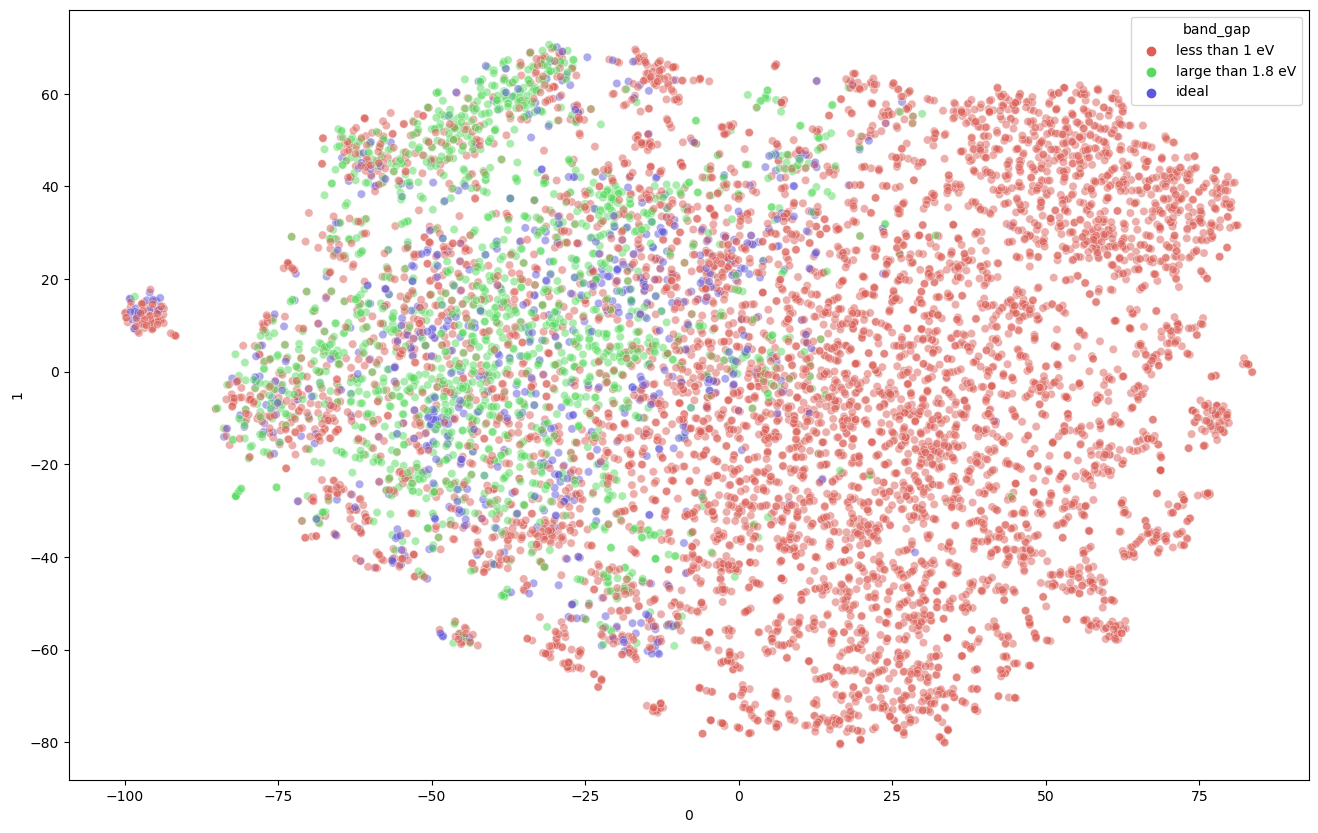

In [18]:
plot_tsne(z,12)

#### mu 

<Axes: xlabel='0', ylabel='1'>

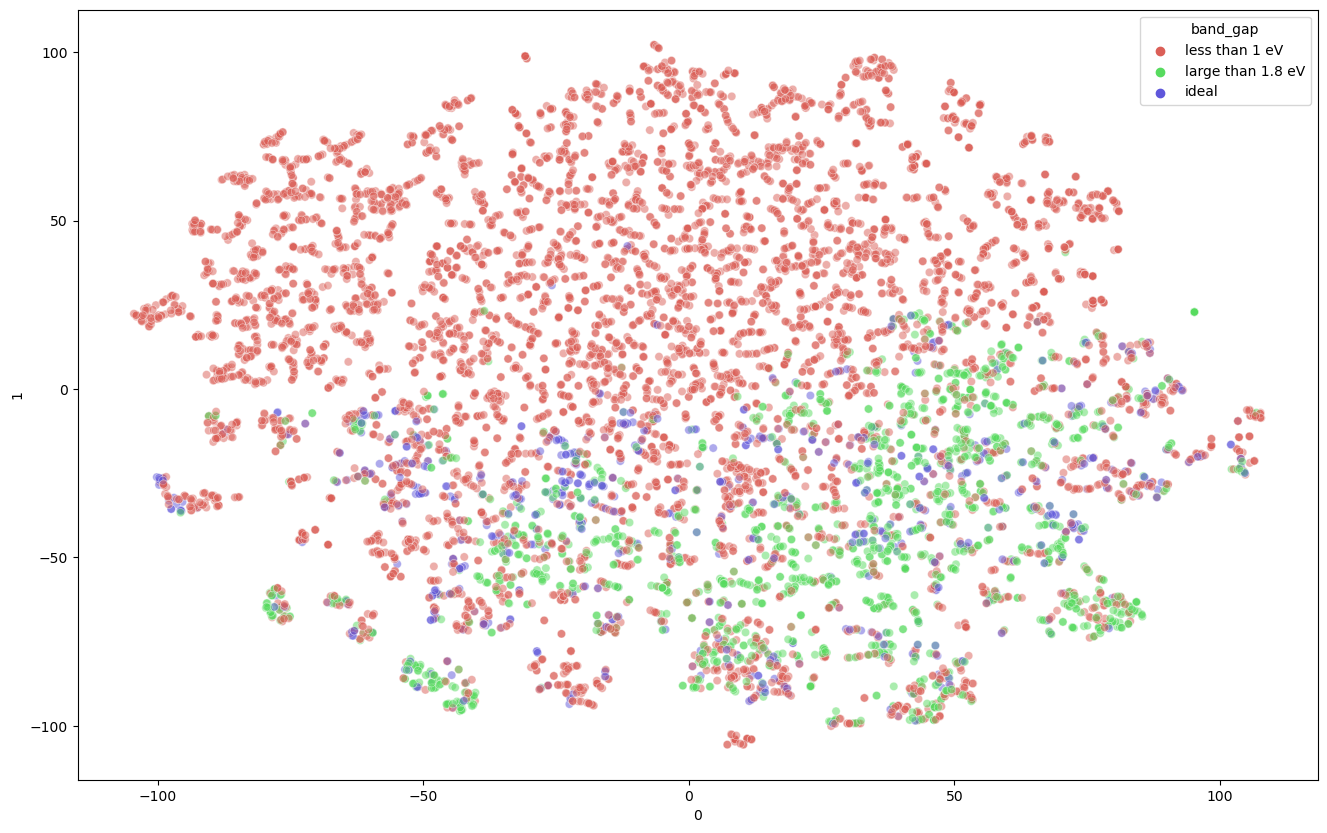

In [8]:
tsne_mu = TSNE(n_components=2,
    perplexity=12,
    init="random",
    n_iter=1000,
).fit_transform(mu)

df_tsne_1 = pd.DataFrame(tsne_mu)
df_tsne_1["band_gap"]=new_band_gap

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=df_tsne_1[0], y=df_tsne_1[1],
    palette=sns.color_palette("hls", 3),
    hue=df_tsne_1["band_gap"],
    data=df_tsne_1,
    alpha=0.5
)

#### log_var

<Axes: xlabel='0', ylabel='1'>

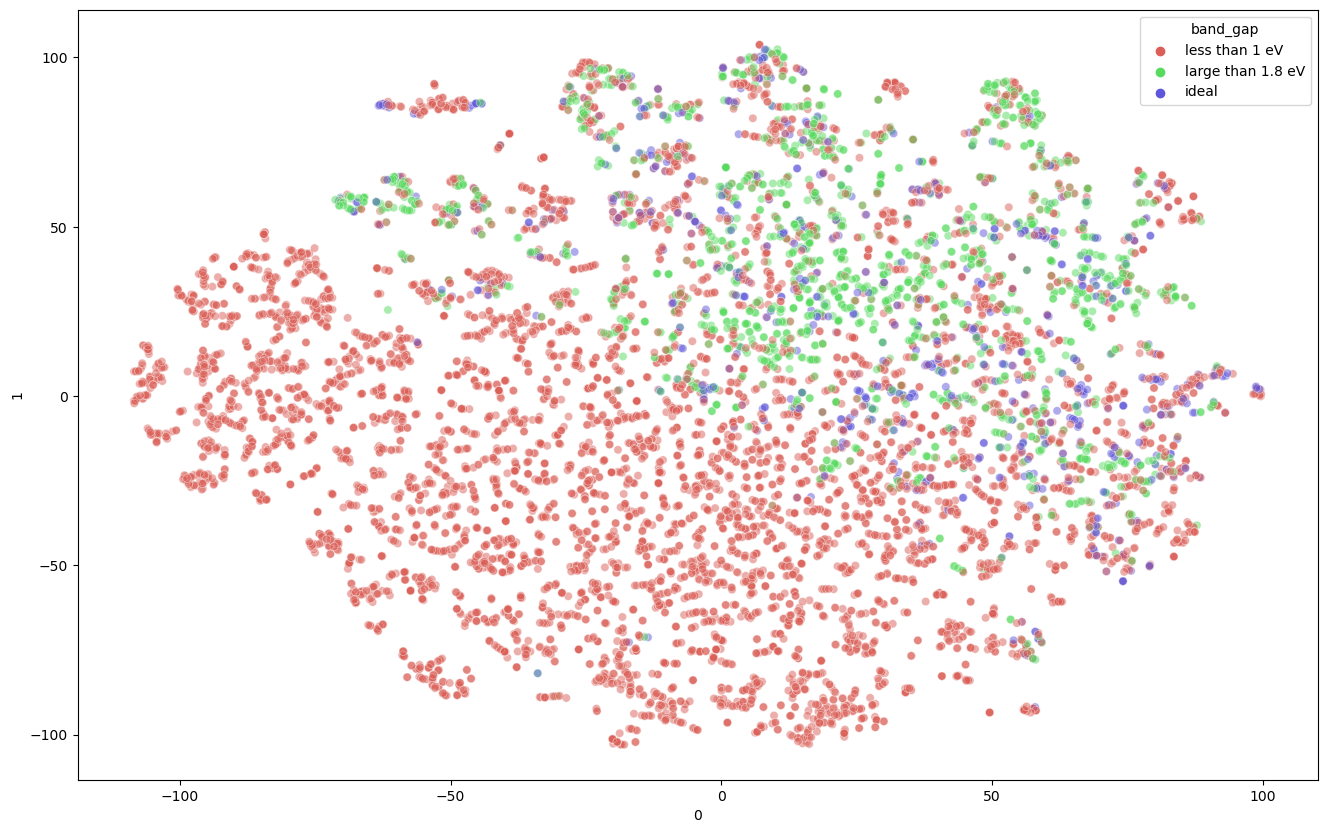

In [36]:
tsne_logvar = TSNE(n_components=2,
    perplexity=12,
    init="random",
    n_iter=1000,
).fit_transform(log_var)

df_tsne_2 = pd.DataFrame(tsne_logvar)
df_tsne_2["band_gap"]=new_band_gap

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=df_tsne_2[0], y=df_tsne_2[1],
    palette=sns.color_palette("hls", 3),
    hue=df_tsne_2["band_gap"],
    data=df_tsne_2,
    alpha=0.5
)

#### z

<Axes: xlabel='0', ylabel='1'>

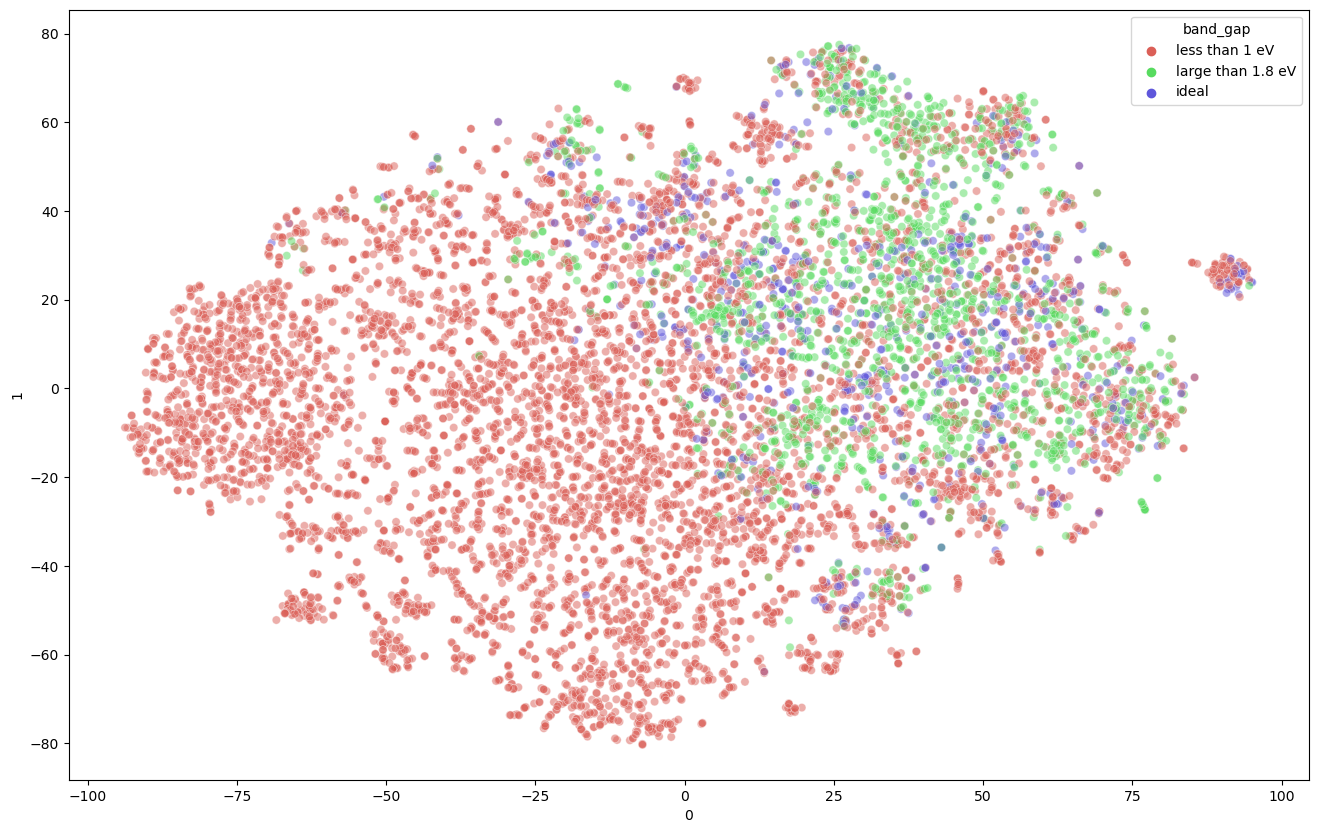

In [22]:
tsne_z = TSNE(n_components=2,
    perplexity=12,
    init="random",
    n_iter=1000,
).fit_transform(z)

df_tsne_z = pd.DataFrame(tsne_z)
df_tsne_z["band_gap"]=new_band_gap

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=df_tsne_z[0], y=df_tsne_z[1],
    palette=sns.color_palette("hls", 3),
    hue=df_tsne_z["band_gap"],
    data=df_tsne_z,
    alpha=0.5
)

#### mu and log_var

<Axes: xlabel='0', ylabel='1'>

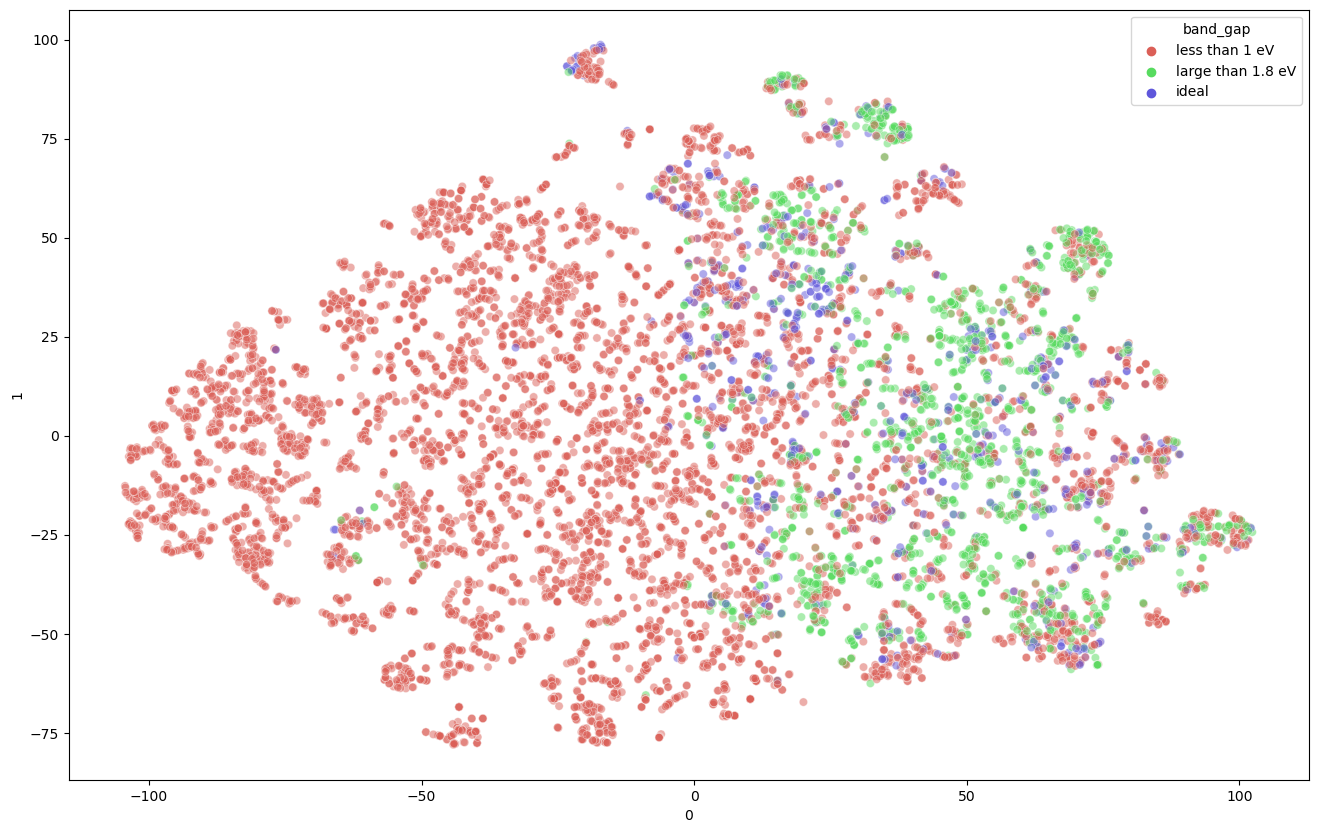

In [24]:
tsne_m_l = TSNE(n_components=2,
    perplexity=25,
    init="random",
    n_iter=1000,
).fit_transform(m_l)

df_tsne_ml = pd.DataFrame(tsne_m_l)
df_tsne_ml["band_gap"]=new_band_gap

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=df_tsne_ml[0], y=df_tsne_ml[1],
    palette=sns.color_palette("hls", 3),
    hue=df_tsne_ml["band_gap"],
    data=df_tsne_ml,
    alpha=0.5
)